# A simpl(er) Introduction to Hierarchical Models 
### Naive Bayesians, 2021


### Agenda

1. EDA Walmart M5 Dataset
2. Hierarchical Regression based on Calendar features

-- 
3. Intro to (non-hierarchical) Autoregressive Modelling with PyMC3


In [74]:
%load_ext nb_black
%reload_ext autoreload
%autoreload 2

from IPython.core.display import display, HTML

display(HTML("<style>.container { width:85% !important; }</style>"))

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [2]:
import os
from scipy import stats
import pandas as pd
import numpy as np
from typing import Dict

# ML libraries
import pymc3 as pm
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor

# Plotting and viz
import matplotlib.pyplot as plt
import seaborn as sns

# Custom libraries
from feature_factory import FeatureFactory

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["font.size"] = 15

<IPython.core.display.Javascript object>

In [3]:
P_ROOT = "../../../hts-forecast/volume/m5-forecasting-accuracy/"
df_sales = pd.read_parquet(os.path.join(P_ROOT, "walmart_m5_sales_dep_state.parquet"))
df_sales.head()

,cat_id,dept_id,state_id,date,qty
0,FOODS,FOODS_1,CA,2011-01-29,1157
1,FOODS,FOODS_1,CA,2011-01-30,1142
2,FOODS,FOODS_1,CA,2011-01-31,787
3,FOODS,FOODS_1,CA,2011-02-01,743
4,FOODS,FOODS_1,CA,2011-02-02,729


<IPython.core.display.Javascript object>

### Visualize the time Series

In [4]:
df_sales_state = (
    df_sales.pivot_table(
        index=["cat_id", "dept_id", "date"], columns="state_id", values="qty"
    )
    .reset_index()
    .set_index("date")
    .rename_axis(None, axis=0)
)
df_sales_state.head()

state_id,cat_id,dept_id,CA,TX,WI
2011-01-29,FOODS,FOODS_1,1157,500,686
2011-01-30,FOODS,FOODS_1,1142,446,628
2011-01-31,FOODS,FOODS_1,787,381,489
2011-02-01,FOODS,FOODS_1,743,317,448
2011-02-02,FOODS,FOODS_1,729,297,183


<IPython.core.display.Javascript object>

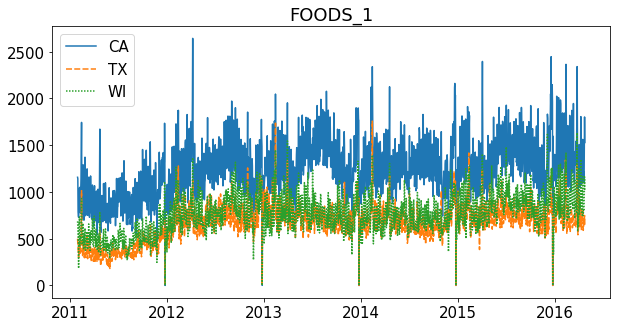

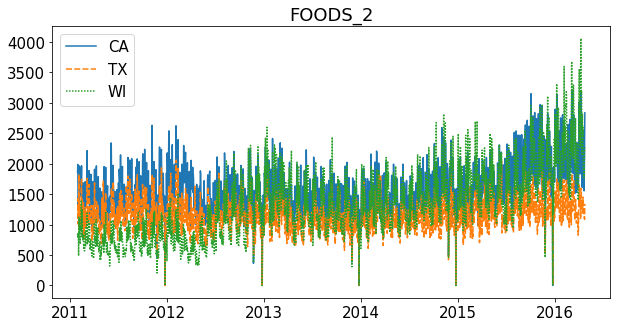

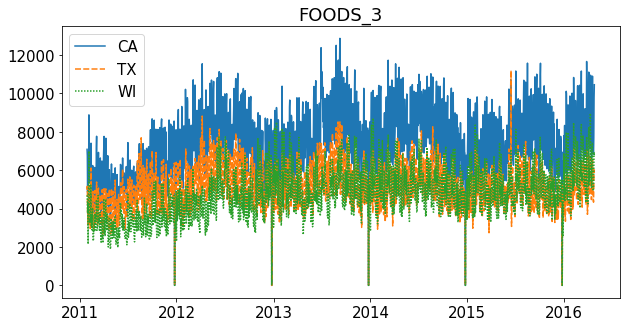

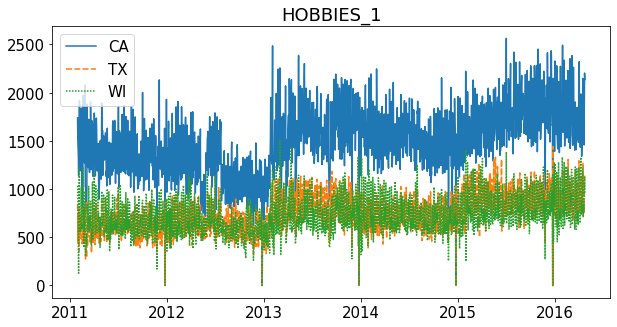

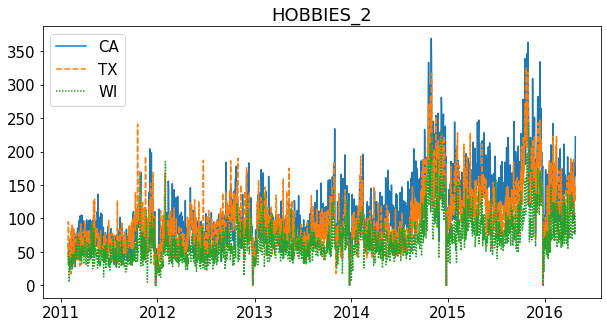

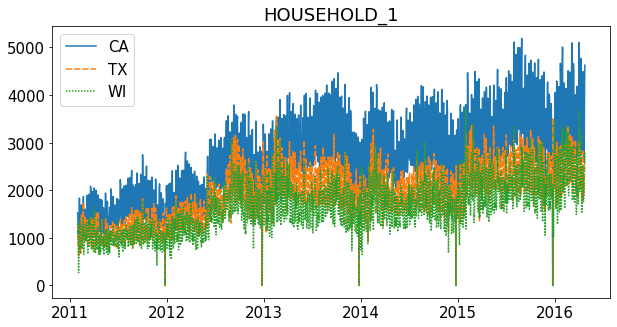

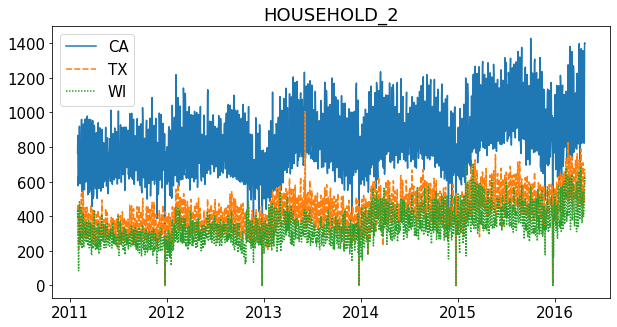

<IPython.core.display.Javascript object>

In [5]:
for name, df_grp in df_sales_state.groupby(["cat_id", "dept_id"]):
    sns.lineplot(data=df_grp.drop(["cat_id", "dept_id"], axis="columns"))
    plt.title("{x}".format(x=name[-1]))
    plt.legend()
    plt.show()

In [6]:
### Use a single
# newdf = df.query('@mean <= closing_price <= @std')

<IPython.core.display.Javascript object>

In [7]:
df_foods_3 = df_sales.query("dept_id in ['FOODS_3']").query(
    "'2014-01-01' <= date <= '2014-12-31'"
)


<IPython.core.display.Javascript object>

In [8]:
df_foods_3

,cat_id,dept_id,state_id,date,qty
12546,FOODS,FOODS_3,CA,2014-01-01,5498
12547,FOODS,FOODS_3,CA,2014-01-02,7149
12548,FOODS,FOODS_3,CA,2014-01-03,8039
12549,FOODS,FOODS_3,CA,2014-01-04,9031
12550,FOODS,FOODS_3,CA,2014-01-05,10047
...,...,...,...,...,...
16732,FOODS,FOODS_3,WI,2014-12-27,4242
16733,FOODS,FOODS_3,WI,2014-12-28,4066
16734,FOODS,FOODS_3,WI,2014-12-29,3433
16735,FOODS,FOODS_3,WI,2014-12-30,3806


<IPython.core.display.Javascript object>

# Build Features (Calendar Features)

In [10]:
ff = FeatureFactory()

<IPython.core.display.Javascript object>

In [11]:
df_features = ff.calendar_features(df_foods_3)
df_features = ff.hierarchical_features(df_features, hierarchical_col="state_id")



<IPython.core.display.Javascript object>

In [12]:
df_features = df_features.set_index(["cat_id", "dept_id", "state_id", "date"])

<IPython.core.display.Javascript object>

In [13]:
df_features.head()

qty  day_of_week  week_of_month  \
cat_id dept_id state_id date                                            
FOODS  FOODS_3 CA       2014-01-01   5498            2              1   
                        2014-01-02   7149            3              1   
                        2014-01-03   8039            4              1   
                        2014-01-04   9031            5              1   
                        2014-01-05  10047            6              1   

                                    week_of_year  month  hierarchical_index  
cat_id dept_id state_id date                                                 
FOODS  FOODS_3 CA       2014-01-01             1      1                   1  
                        2014-01-02             1      1                   1  
                        2014-01-03             1      1                   1  
                        2014-01-04             1      1                   1  
                        2014-01-05             1      1                   1

<IPython.core.display.Javascript object>

# Building a Regular Linear Regression Model

In [15]:
len(df_features)

1095

<IPython.core.display.Javascript object>

In [16]:
X, y = df_features[ff.features], df_features["qty"]

display(X.head())
display(y.head())

day_of_week  week_of_month  week_of_year  \
cat_id dept_id state_id date                                                   
FOODS  FOODS_3 CA       2014-01-01            2              1             1   
                        2014-01-02            3              1             1   
                        2014-01-03            4              1             1   
                        2014-01-04            5              1             1   
                        2014-01-05            6              1             1   

                                    month  
cat_id dept_id state_id date               
FOODS  FOODS_3 CA       2014-01-01      1  
                        2014-01-02      1  
                        2014-01-03      1  
                        2014-01-04      1  
                        2014-01-05      1

cat_id  dept_id  state_id  date      
FOODS   FOODS_3  CA        2014-01-01     5498
                           2014-01-02     7149
                           2014-01-03     8039
                           2014-01-04     9031
                           2014-01-05    10047
Name: qty, dtype: int64

<IPython.core.display.Javascript object>

In [17]:
# Sklearn pipeline
# Column Transformer
# Model
# k-fold cross-validation (or time series cross-val)
# hyper-parameter tuning

<IPython.core.display.Javascript object>

In [18]:
mod = LinearRegression()
mod.fit(X, y)
yhat = mod.predict(X)

<IPython.core.display.Javascript object>

(500, 100)

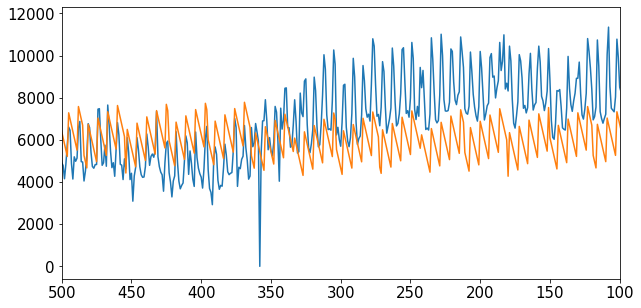

<IPython.core.display.Javascript object>

In [19]:
plt.plot(y.reset_index()["qty"])
plt.plot(yhat)
plt.xlim([500, 100])

# Building a Bayesian Linear Regression Model

In [20]:
n_features = len(ff.features)
n_hierarchies = X.reset_index()["state_id"].nunique()

index_rows = tuple(np.arange(len(df_features)))
index_cols = tuple(df_features["hierarchical_index"].values)


with pm.Model() as bmod:
    #     mu_w = pm.Normal("mu_w", mu=0, sigma=100, shape=(n_features, 1))
    #     sig_w = pm.HalfNormal("sig_w", 100)

    w = pm.Normal("w", mu=0, sigma=100, shape=(n_features, n_hierarchies))

    sig_obs = pm.HalfNormal("sig_obs", 100)

    mu = (X.values @ w)[index_rows, index_cols]

    # Likelihood
    obs = pm.Normal("obs", mu=mu, sigma=sig_obs, observed=y.values)

    trace = pm.sample(draws=2000)

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sig_obs, w]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 324 seconds.
/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


<IPython.core.display.Javascript object>

In [21]:
with bmod:
    display(pm.summary(trace))

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"w[0,0]",612.248,36.442,545.802,678.460,0.471,0.335,5974.0,5921.0,5973.0,3154.0,1.0
"w[0,1]",880.323,35.459,812.673,945.840,0.482,0.342,5412.0,5376.0,5444.0,2890.0,1.0
"w[0,2]",561.227,35.827,495.055,628.531,0.506,0.361,5020.0,4933.0,5007.0,2454.0,1.0
"w[1,0]",446.975,42.737,362.010,523.774,0.577,0.408,5489.0,5481.0,5492.0,3406.0,1.0
"w[1,1]",780.052,42.373,697.389,854.648,0.620,0.440,4667.0,4633.0,4631.0,2800.0,1.0
"w[1,2]",502.809,42.610,426.999,582.301,0.620,0.439,4730.0,4718.0,4726.0,3045.0,1.0
"w[2,0]",-20.267,15.339,-50.065,7.530,0.244,0.197,3963.0,3043.0,3967.0,2730.0,1.0
"w[2,1]",-11.508,15.226,-39.060,17.568,0.238,0.204,4083.0,2773.0,4085.0,2949.0,1.0
"w[2,2]",-8.960,15.321,-38.323,19.515,0.255,0.247,3611.0,1925.0,3607.0,2399.0,1.0
"w[3,0]",297.380,63.246,180.617,413.254,1.016,0.734,3876.0,3709.0,3872.0,2702.0,1.0


<IPython.core.display.Javascript object>

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


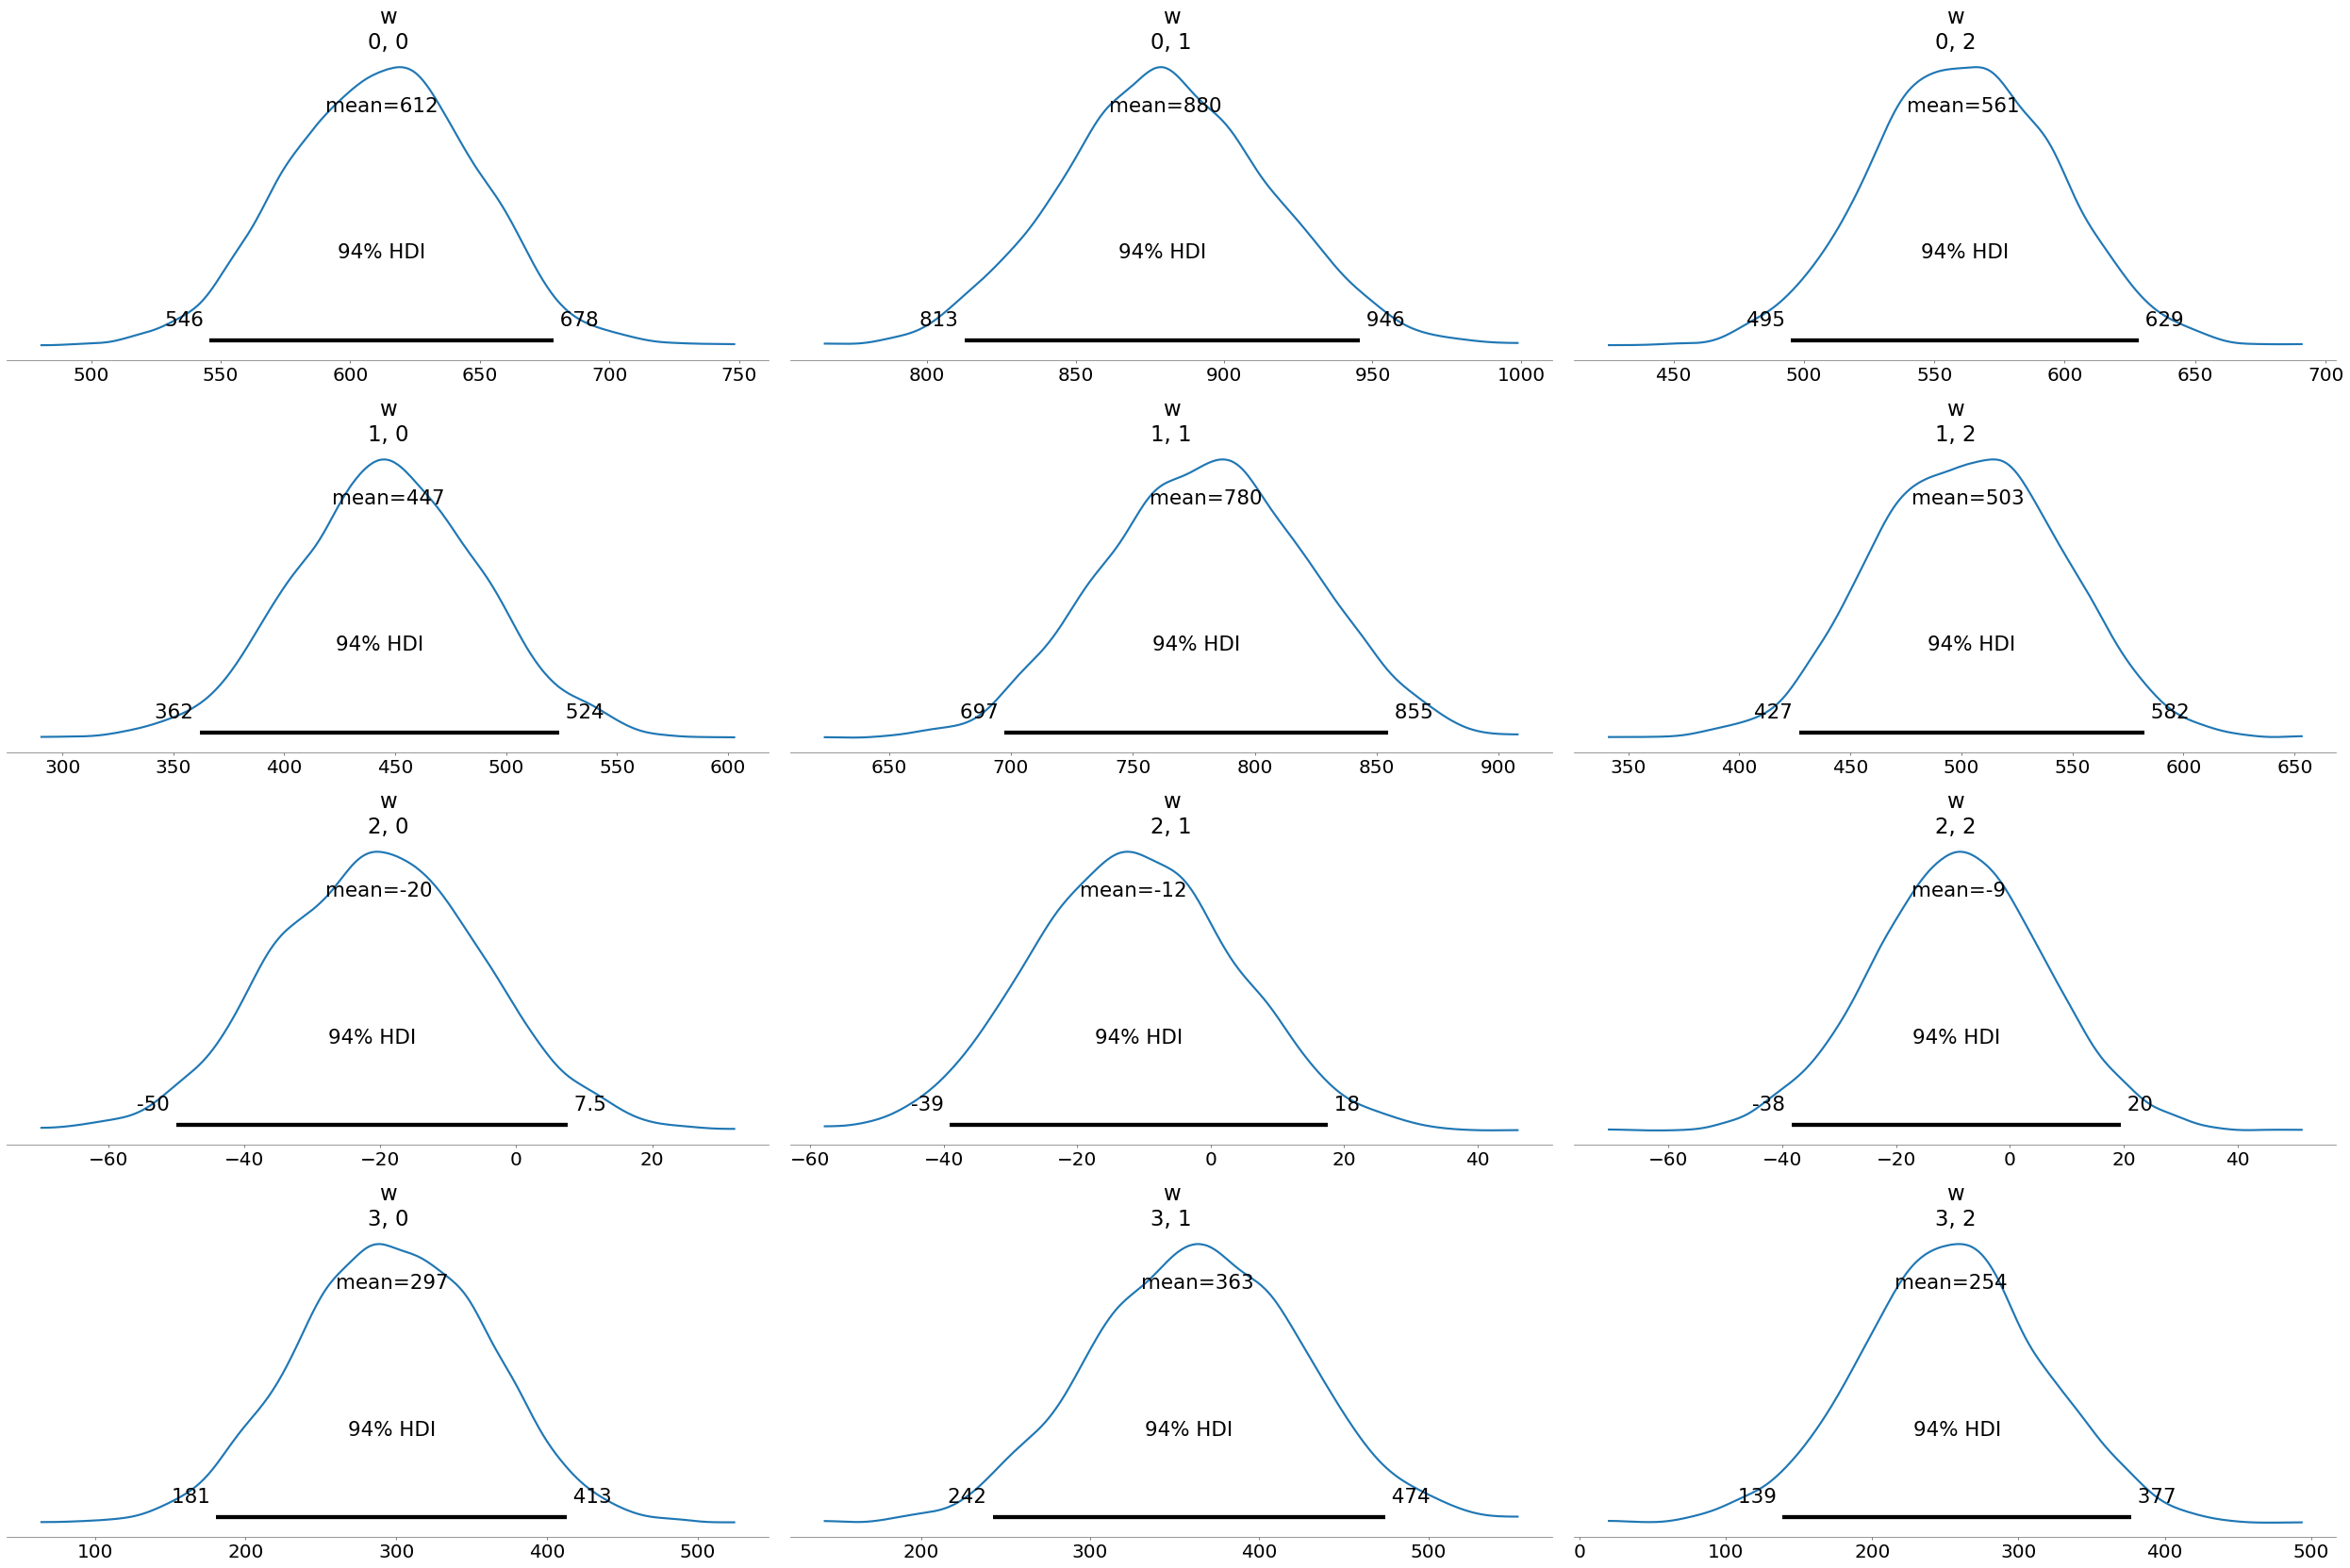

<IPython.core.display.Javascript object>

In [23]:
pm.plot_posterior(trace, var_names=["w"], textsize=20)
plt.show()

In [ ]:
trace.get_values(varname="w").mean(axis=0)

# Building a Hierarchical Time Series

In [24]:
n_features = len(ff.features)
n_hierarchies = X.reset_index()["state_id"].nunique()

index_rows = tuple(np.arange(len(df_features)))
index_cols = tuple(df_features["hierarchical_index"].values)


with pm.Model() as bmod:
    #     Prior
    mu_w = pm.Normal("mu_w", mu=0, sigma=100, shape=(n_features, 1))
    sig_w = pm.HalfNormal("sig_w", 100)

    w = pm.Normal("w", mu=mu_w, sigma=sig_w, shape=(n_features, n_hierarchies))

    sig_obs = pm.HalfNormal("sig_obs", 100)
   
    #     Likelihood
    mu = (X.values @ w)[index_rows, index_cols]

    obs = pm.Normal("obs", mu=mu, sigma=sig_obs, observed=y.values)
    
    #     Posterior

    trace = pm.sample(draws=2000)

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sig_obs, w, sig_w, mu_w]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 467 seconds.


<IPython.core.display.Javascript object>

In [25]:
with bmod:
    display(pm.summary(trace))

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
"mu_w[0,0]",161.643,97.730,-9.427,356.485,1.344,1.081,5286.0,4087.0,5291.0,2902.0,1.0
"mu_w[1,0]",141.399,96.945,-30.583,335.847,1.387,1.060,4888.0,4181.0,4926.0,2910.0,1.0
"mu_w[2,0]",-12.236,89.569,-192.393,145.188,1.103,1.747,6596.0,1315.0,6605.0,2638.0,1.0
"mu_w[3,0]",96.253,90.929,-74.009,262.461,1.141,1.036,6348.0,3856.0,6369.0,3067.0,1.0
"w[0,0]",660.667,37.924,587.156,729.646,0.450,0.320,7097.0,7029.0,7096.0,2932.0,1.0
"w[0,1]",946.082,38.234,874.579,1017.030,0.470,0.333,6614.0,6585.0,6626.0,3206.0,1.0
"w[0,2]",602.933,38.364,531.545,674.993,0.504,0.358,5792.0,5735.0,5778.0,3156.0,1.0
"w[1,0]",496.874,48.296,414.629,598.616,0.586,0.418,6792.0,6676.0,6825.0,2934.0,1.0
"w[1,1]",878.978,47.834,789.044,968.063,0.626,0.443,5846.0,5836.0,5885.0,3010.0,1.0
"w[1,2]",568.330,46.337,479.331,652.529,0.591,0.421,6140.0,6062.0,6120.0,3093.0,1.0


<IPython.core.display.Javascript object>

In [75]:
# pm.plot_posterior(trace, var_names=["w"], textsize=20)
# plt.show()

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


KeyError: 'var names: "[\'w\'] are not present" in dataset'

<IPython.core.display.Javascript object>

In [ ]:
# ToDo:
#   Hierarchical AR(p)
#   Rename model params
#   Visualise Time Series predictions

## Autoregressive Models

In [59]:
def generate_ar(p: int = 1, true_theta: float = 0.7) -> np.array:

    if p != 1:
        raise NotImplementedError("Wait for it... ;)")

    T = 10000
    ar_signal = np.zeros((T,))

    # true stationarity:
    #     true_theta = 0.7
    # true standard deviation of the innovation:
    true_sigma = 1.0
    # true process mean:
    true_center = 0.0

    for t in range(1, T):
        ar_signal[t] = true_theta * ar_signal[t - 1] + np.random.normal(
            loc=true_center, scale=true_sigma
        )

    ar_signal = ar_signal[-5000:]

    return ar_signal


ar_sig = generate_ar(p=1, true_theta=0.7)

<IPython.core.display.Javascript object>

In [55]:
with pm.Model() as armod:
    theta = pm.Uniform("theta", 0.0, 1)
    # precision of the innovation term
#     tau = pm.Exponential("tau", 0.5)
    # process mean
#     center = pm.Normal("center", mu=0.0, sigma=1.0)

    likelihood = pm.AR1("obs", k=theta, tau_e=1, observed=ar_sig)

    trace = pm.sample(1000, tune=2000, init="advi+adapt_diag")


Auto-assigning NUTS sampler...
INFO:pymc3:Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
INFO:pymc3:Initializing NUTS using advi+adapt_diag...


Convergence achieved at 8800
INFO:pymc3.variational.inference:Convergence achieved at 8800
Interrupted at 8,799 [4%]: Average Loss = 7,183.7
INFO:pymc3.variational.inference:Interrupted at 8,799 [4%]: Average Loss = 7,183.7
Multiprocess sampling (2 chains in 2 jobs)
INFO:pymc3:Multiprocess sampling (2 chains in 2 jobs)
NUTS: [theta]
INFO:pymc3:NUTS: [theta]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 39 seconds.
INFO:pymc3:Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 39 seconds.


<IPython.core.display.Javascript object>

In [56]:
with armod:
    display(pm.summary(trace))

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.686,0.01,0.665,0.704,0.0,0.0,732.0,732.0,732.0,1415.0,1.0


<IPython.core.display.Javascript object>

/opt/anaconda3/envs/homework/lib/python3.7/site-packages/arviz/data/io_pymc3.py:92: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


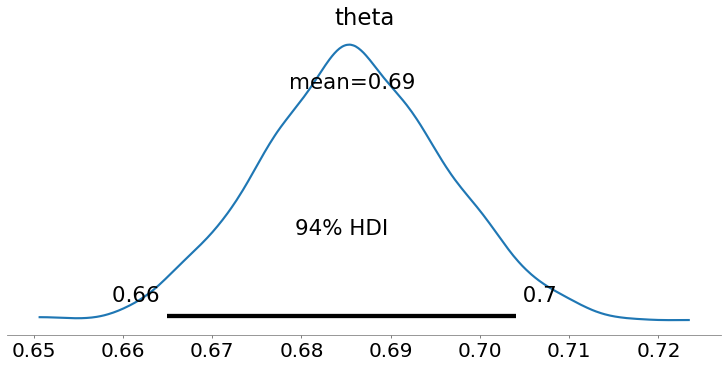

<IPython.core.display.Javascript object>

In [57]:
pm.plot_posterior(trace, var_names=["theta"], textsize=20)
plt.show()

In [65]:
T_half = int(len(ar_sig_hierarchical)/2)

T_half

ar_sig_hierarchical = np.append(
    generate_ar(p=1, true_theta=0.7), generate_ar(p=1, true_theta=-0.5)
)

index_ = np.append(np.zeros(T_half, dtype=np.int8), np.ones(T_half, dtype=np.int8))


<IPython.core.display.Javascript object>

In [73]:
with pm.Model() as armod_hierarchical:
    theta = pm.Uniform("theta", lower=-1, upper=1, shape=2)
    # precision of the innovation term
#     tau = pm.Exponential("tau", 0.5)
    # process mean
#     center = pm.Normal("center", mu=0.0, sigma=1.0)

    likelihood = pm.AR("obs", rho=theta[index_], sigma=1, observed=ar_sig_hierarchical)

    trace = pm.sample(1000, tune=2000, init="advi+adapt_diag")



KeyboardInterrupt: 

<IPython.core.display.Javascript object>

In [63]:
?pm.Uniform

<IPython.core.display.Javascript object>

array([0, 0, 0, ..., 1, 1, 1], dtype=int8)

<IPython.core.display.Javascript object>

In [68]:
T_half

5000

<IPython.core.display.Javascript object>

In [70]:
len(index_)

10000

<IPython.core.display.Javascript object>

In [72]:
?pm.AR

<IPython.core.display.Javascript object>